In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')
import joblib

plt.style.use('seaborn-white')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print('所有库导入成功')

所有库导入成功


In [2]:
try:
    df = pd.read_csv(f'D:\下载\LoanStats\LoanStats_2017Q1.csv',skiprows=1,low_memory=False,encoding='gbk')
    print('导入数据成功')
except FileNotFoundError:
    print('找不到数据文件,请检查文件路径')

print('数据集基本信息:')
print(f'数据集形状:{df.shape}')
print(f'数据列数:{len(df.columns)}')
print('\n前5行数据:')
display(df.head())

导入数据成功
数据集基本信息:
数据集形状:(96783, 145)
数据列数:145

前5行数据:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,8400.0,8400.0,8400.0,36 months,11.39%,276.56,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,20000.0,20000.0,20000.0,36 months,10.49%,649.96,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,15000.0,15000.0,15000.0,36 months,5.32%,451.73,A,A1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,13000.0,13000.0,13000.0,36 months,11.44%,428.32,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,14000.0,14000.0,14000.0,60 months,15.99%,340.38,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print('贷款状态分布:')
print(df['loan_status'].value_counts())

def create_target(status):
    if status in ['Charged Off','Default']:
        return 1
    elif status in ['Fully Paid','Current']:
        return 0
    else:
        return -1

df['target'] = df['loan_status'].apply(create_target)
df = df[df['target'] != -1]
print(f'\n处理后数据量:{len(df)}')
print(f"坏账率:{df['target'].mean():.3f}")

贷款状态分布:
loan_status
Current               64310
Fully Paid            23381
Charged Off            5740
Late (31-120 days)     1872
In Grace Period         878
Late (16-30 days)       473
Default                 125
Name: count, dtype: int64

处理后数据量:93556
坏账率:0.063


In [4]:
features = ['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_length','home_ownership','annual_inc','verification_status','purpose','dti','delinq_2yrs','inq_last_6mths','mths_since_last_delinq','open_acc','pub_rec','revol_bal','revol_util','total_acc','initial_list_status','application_type']
analysis_df = df[features + ['target']].copy()

print(f'分析数据集形状:{analysis_df.shape}')
print(f'分析数据集数据类型:{analysis_df.dtypes}')

分析数据集形状:(93556, 23)
分析数据集数据类型:loan_amnt                 float64
term                       object
int_rate                   object
installment               float64
grade                      object
sub_grade                  object
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
purpose                    object
dti                       float64
delinq_2yrs               float64
inq_last_6mths            float64
mths_since_last_delinq    float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                 object
total_acc                 float64
initial_list_status        object
application_type           object
target                      int64
dtype: object


In [5]:
print("缺失值统计:")
missing_data = analysis_df.isnull().sum()
print(missing_data)

analysis_df['int_rate'] = analysis_df['int_rate'].str.replace('%','').astype(float)
analysis_df['revol_util'] = analysis_df['revol_util'].str.replace('%','').astype(float)

analysis_df['dti'] = analysis_df['dti'].fillna(analysis_df['dti'].mean())
analysis_df['emp_length'] = analysis_df['emp_length'].fillna('0 years')
analysis_df['revol_util'] = analysis_df['revol_util'].fillna(analysis_df['revol_util'].median())
analysis_df['mths_since_last_delinq'] = analysis_df['mths_since_last_delinq'].fillna(999)

def convert_emp_length(emp_str):
    if pd.isna(emp_str):
        return 0
    if emp_str == '< 1 year':
        return 0
    if emp_str == '10+ years':
        return 10
    try:
        return int(emp_str.split()[0])
    except:
        return 0

analysis_df['emp_length_num'] = analysis_df['emp_length'].apply(convert_emp_length)
grade_map = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}
analysis_df['grade_num'] = analysis_df['grade'].map(grade_map)

analysis_df['loan_to_income'] = analysis_df['loan_amnt'] / analysis_df['annual_inc']

analysis_df.loc[analysis_df['loan_to_income'] > 1,'loan_to_income'] = 1

print(f'预处理后数据形状:{analysis_df.shape}')
print(analysis_df.info())
print(analysis_df.head())

缺失值统计:
loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                 6541
home_ownership                0
annual_inc                    0
verification_status           0
purpose                       0
dti                          33
delinq_2yrs                   0
inq_last_6mths                0
mths_since_last_delinq    44912
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   48
total_acc                     0
initial_list_status           0
application_type              0
target                        0
dtype: int64
预处理后数据形状:(93556, 26)
<class 'pandas.core.frame.DataFrame'>
Index: 93556 entries, 0 to 96777
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amn

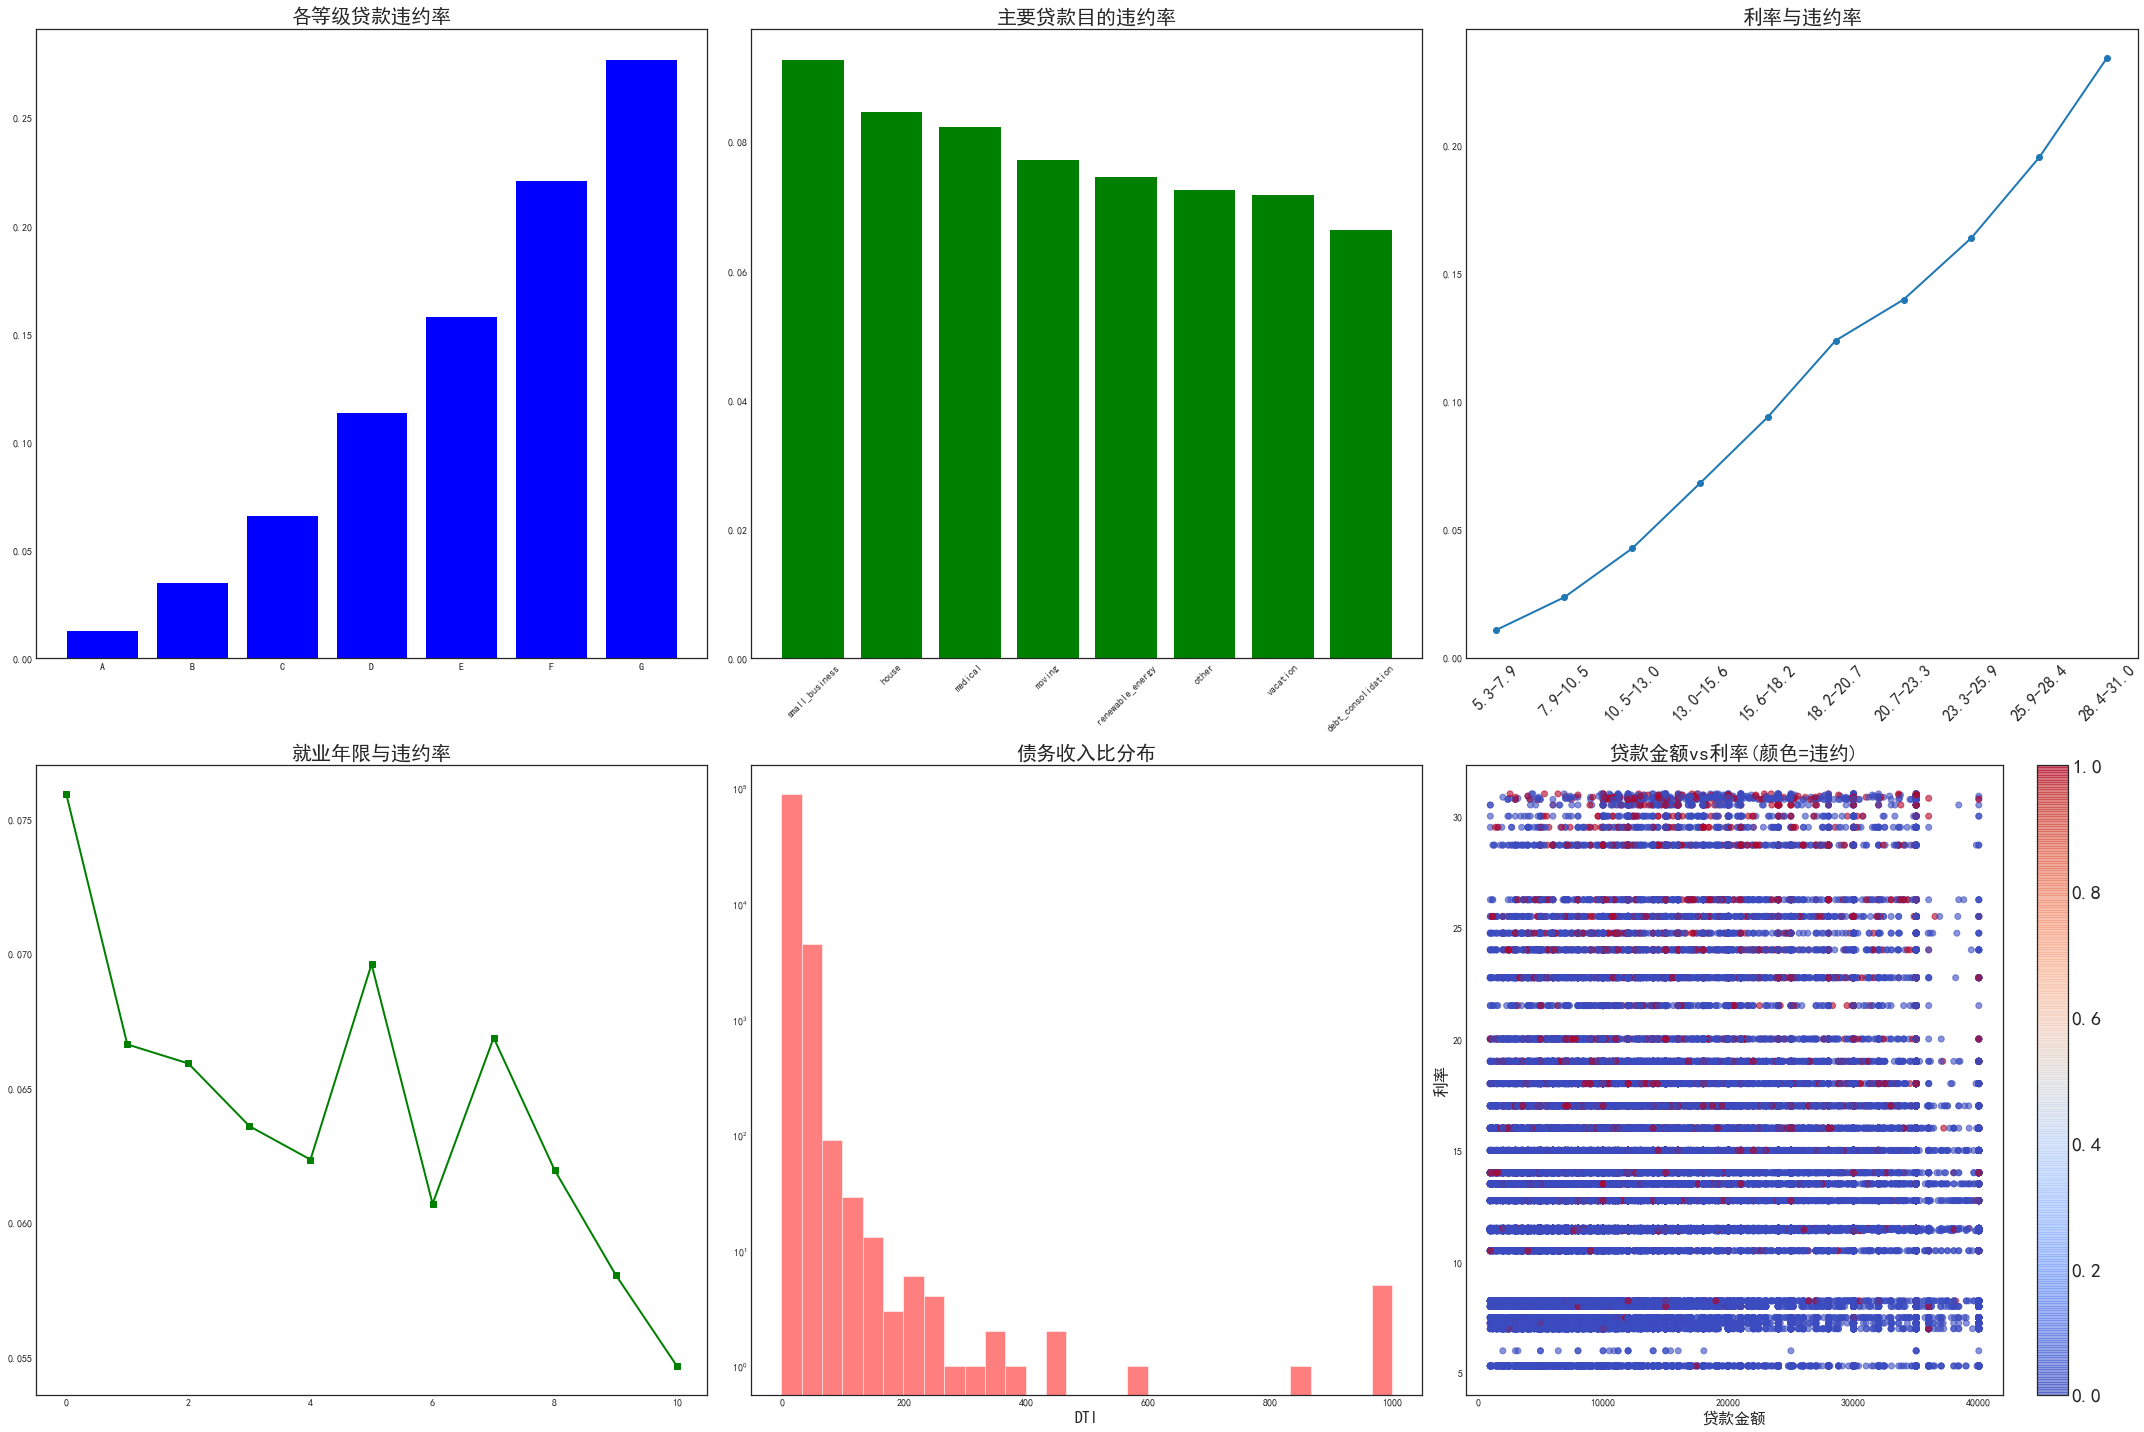

In [6]:
fig,axes = plt.subplots(2,3,figsize=(30,20))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

grade_default = analysis_df.groupby('grade')['target'].mean().sort_index()
axes[0,0].bar(grade_default.index.to_numpy(),grade_default.values,color='b')
axes[0,0].set_title('各等级贷款违约率',fontsize=20,fontweight='bold')

purpose_default = analysis_df.groupby('purpose')['target'].mean().sort_values(ascending=False)
axes[0,1].bar(purpose_default.head(8).index.to_numpy(),purpose_default.head(8).values,color='g')
axes[0,1].set_title('主要贷款目的违约率',fontsize=20,fontweight='bold')
axes[0,1].tick_params(axis='x',rotation=45)

analysis_df['int_rate_bin'] = pd.cut(analysis_df['int_rate'],bins=10)
int_rate_default = analysis_df.groupby('int_rate_bin')['target'].mean()
axes[0,2].plot(range(len(int_rate_default)),int_rate_default.values,marker='o',linewidth=2)
axes[0,2].set_title('利率与违约率',fontsize=20,fontweight='bold')
axes[0,2].set_xticks(range(len(int_rate_default)))
axes[0,2].set_xticklabels([f'{interval.left:.1f}-{interval.right:.1f}'for interval in int_rate_default.index],rotation=45,fontsize=16)

emp_default = analysis_df.groupby('emp_length_num')['target'].mean()
axes[1,0].plot(emp_default.index.to_numpy(),emp_default.values,color='g',linewidth=2,marker='s')
axes[1,0].set_title('就业年限与违约率',fontsize=20,fontweight='bold')

axes[1,1].hist(analysis_df['dti'],bins=30,alpha=0.5,color='r')
axes[1,1].set_title('债务收入比分布',fontsize=20,fontweight='bold')
axes[1,1].set_xlabel('DTI',fontsize=16)
axes[1,1].set_yscale('log')

scatter = axes[1,2].scatter(analysis_df['loan_amnt'],analysis_df['int_rate'],c=analysis_df['target'],alpha=0.6,cmap='coolwarm')
axes[1,2].set_title('贷款金额vs利率(颜色=违约)',fontsize=20,fontweight='bold')
axes[1,2].set_xlabel('贷款金额',fontsize=16)
axes[1,2].set_ylabel('利率',fontsize=16)
plt.colorbar(scatter,ax=axes[1,2])

plt.tight_layout()
plt.show()

In [7]:
final_features = ['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_length','home_ownership','annual_inc','verification_status','purpose','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','loan_to_income','grade_num']

model_df = analysis_df[final_features + ['target']].copy()

categorical_cols = model_df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'target']
print('需要编码的类别列:',categorical_cols)
model_encoded = pd.get_dummies(model_df,columns=categorical_cols,drop_first=True)

print(f'编码后特征数量:{model_encoded.shape[1] - 1}')

需要编码的类别列: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']
编码后特征数量:83


Logistic Regression:
测试集AUC:0.5429
交叉验证AUC:0.5283(+/-)0.0309
Random Forest:
测试集AUC:0.6830
交叉验证AUC:0.6905(+/-)0.0168
Gradient Boosting:
测试集AUC:0.7082
交叉验证AUC:0.7184(+/-)0.0216


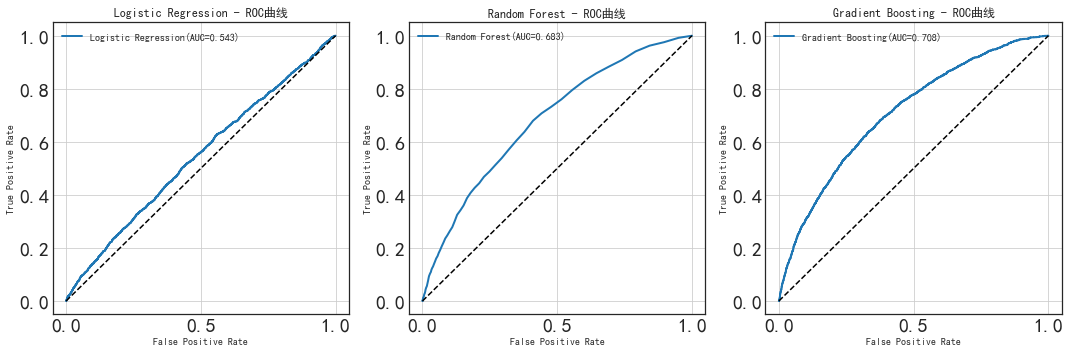

In [8]:
X = model_encoded.drop('target',axis=1)
y = model_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

models = {
    'Logistic Regression':LogisticRegression(max_iter=1000,random_state=42),
    'Random Forest':RandomForestClassifier(n_estimators=200,random_state=42),
    'Gradient Boosting':GradientBoostingClassifier(n_estimators=200,random_state=42),
}
results = {}
plt.figure(figsize=(15,5))

for i,(name,model) in enumerate(models.items()):
    model.fit(X_train,y_train)

    y_pred_proba = model.predict_proba(X_test)[:,1]

    auc_score = roc_auc_score(y_test,y_pred_proba)
    cv_score = cross_val_score(model,X_train,y_train,cv=5,scoring='roc_auc')

    results[name] = {
        'model':model,
        'auc':auc_score,
        'cv_mean':cv_score.mean(),
        'cv_std':cv_score.std()
    }
    print(f'{name}:')
    print(f'测试集AUC:{auc_score:.4f}')
    print(f'交叉验证AUC:{cv_score.mean():.4f}(+/-){cv_score.std()*2:.4f}')

    fpr,tpr,thresholds = roc_curve(y_test,y_pred_proba)
    plt.subplot(1,3,i+1)
    plt.plot(fpr,tpr,label=f'{name}(AUC={auc_score:.3f})',linewidth=2)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC曲线')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
param_grid = {
    'n_estimators':[100,200],
    'max_depth':[10,15,20],
    'min_samples_split':[8,10,12],
    'min_samples_leaf':[3,4,5],
    'class_weight':['balanced',None]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf,param_grid=param_grid,cv=5,scoring='roc_auc',n_jobs=-1)
grid_search.fit(X_train,y_train)

print('最佳参数:',grid_search.best_params_)
print('最佳分数:',grid_search.best_score_)

最佳参数: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}
最佳分数: 0.7158473985484441



随机森林详细评估
测试集AUC:0.7067

分类报告:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     26307
           1       0.00      0.00      0.00      1760

    accuracy                           0.94     28067
   macro avg       0.47      0.50      0.48     28067
weighted avg       0.88      0.94      0.91     28067



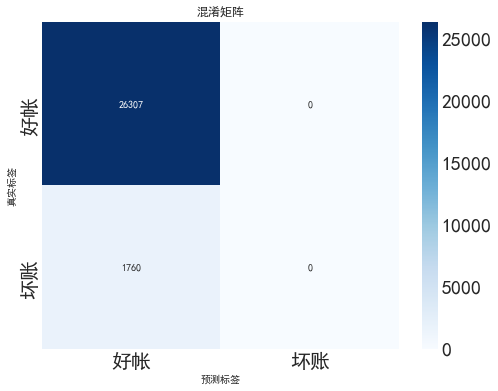


随机森林详细评估
测试集AUC:0.7045

分类报告:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     26307
           1       0.12      0.57      0.19      1760

    accuracy                           0.70     28067
   macro avg       0.54      0.64      0.51     28067
weighted avg       0.91      0.70      0.78     28067



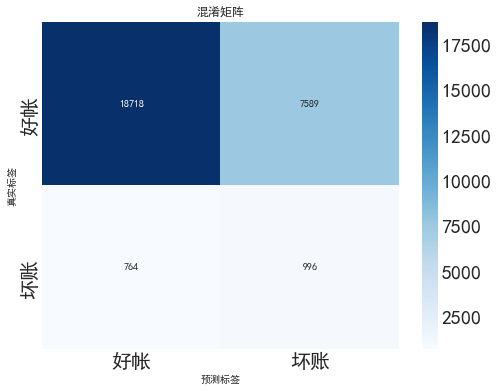

In [16]:
best_rf1 = grid_search.best_estimator_
y_pred = best_rf1.predict(X_test)
y_pred_proba = best_rf1.predict_proba(X_test)[:,1]

print('\n随机森林详细评估')
print(f'测试集AUC:{roc_auc_score(y_test,y_pred_proba):.4f}')
print('\n分类报告:')
print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=['好帐','坏账'],yticklabels=['好帐','坏账'])
plt.title('混淆矩阵')
plt.ylabel('真实标签')
plt.xlabel('预测标签')
plt.show()

best_rf2 = RandomForestClassifier(random_state=42,class_weight='balanced',max_depth=10,min_samples_leaf=4,min_samples_split=8,n_estimators=200)
best_rf2.fit(X_train,y_train)
y_pred = best_rf2.predict(X_test)
y_pred_proba = best_rf2.predict_proba(X_test)[:,1]

print('\n随机森林详细评估')
print(f'测试集AUC:{roc_auc_score(y_test,y_pred_proba):.4f}')
print('\n分类报告:')
print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=['好帐','坏账'],yticklabels=['好帐','坏账'])
plt.title('混淆矩阵')
plt.ylabel('真实标签')
plt.xlabel('预测标签')
plt.show()

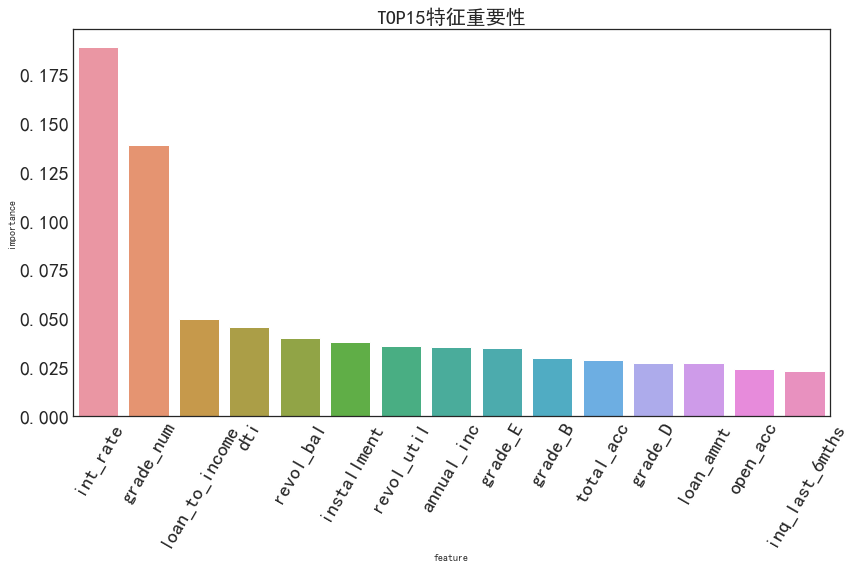

最重要的10个特征:
 2.int_rate:0.1889
14.grade_num:0.1390
13.loan_to_income:0.0493
 5.dti:0.0452
10.revol_bal:0.0397
 3.installment:0.0379
11.revol_util:0.0355
 4.annual_inc:0.0350
19.grade_E:0.0347
16.grade_B:0.0296


In [18]:
feature_importance = pd.DataFrame({
    'feature':X.columns,
    'importance':best_rf2.feature_importances_
}).sort_values('importance',ascending=False)

plt.figure(figsize=(12,8))

sns.barplot(data=feature_importance.head(15),x='feature',y='importance')
plt.title('TOP15特征重要性',fontsize=20,fontweight='bold')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

print('最重要的10个特征:')
for i,row in feature_importance.head(10).iterrows():
    print(f"{i+1:2d}.{row['feature']}:{row['importance']:.4f}")

In [12]:
print('深入业务洞察:')
print('='*50)

grade_risk = analysis_df.groupby('grade').agg({
    'target':['mean','count'],
    'int_rate':'mean',
}).round(4)
grade_risk.columns = ['违约率','贷款数量','平均利率']
print('\n1.各等级风险分析:')
print(grade_risk)

print('\n2.关键阈值分析:')
print(f"利率>15%的违约率:{analysis_df[analysis_df['int_rate']>15]['target'].mean():.3f}")
print(f"DTI>20的违约率:{analysis_df[analysis_df['dti']>20]['target'].mean():.3f}")
print(f"循环信用使用率>70%的违约率:{analysis_df[analysis_df['revol_util']>70]['target'].mean():.3f}")

print('\n3.高风险组合分析:')
high_risk_conditions = []
if 'int_rate' in analysis_df.columns: high_risk_conditions.append(analysis_df['int_rate'] > 15)
if 'dti' in analysis_df.columns: high_risk_conditions.append(analysis_df['dti'] > 20)
if 'grade_num' in analysis_df.columns: high_risk_conditions.append(analysis_df['grade_num'] >= 5)

if high_risk_conditions:
    high_risk_combo = analysis_df[np.all(high_risk_conditions, axis=0)]
    if len(high_risk_combo) > 0:
        print(f"高风险组合违约率: {high_risk_combo['target'].mean():.3f}")
        print(f"高风险组合数量: {len(high_risk_combo)}")

深入业务洞察:

1.各等级风险分析:
          违约率   贷款数量     平均利率
grade                        
A      0.0130  14821   6.9151
B      0.0354  28133  10.6045
C      0.0663  32423  14.1285
D      0.1139  11370  18.2342
E      0.1582   4748  24.2194
F      0.2210   1588  29.4803
G      0.2770    473  30.8673

2.关键阈值分析:
利率>15%的违约率:0.125
DTI>20的违约率:0.076
循环信用使用率>70%的违约率:0.071

3.高风险组合分析:
高风险组合违约率: 0.184
高风险组合数量: 3822


In [17]:
joblib.dump(best_rf2,'lending_club_model_no_fico.pkl')

model_info = {
    'features':X.columns.tolist(),
    'feature_importance':feature_importance.to_dict(),
    'performance':{
        'auc':roc_auc_score(y_test,y_pred_proba),
        'best_params':grid_search.best_params_
    }
}
print('模型已保存,可用于生产环境')
print(f'最终模型性能:AUC = {roc_auc_score(y_test,y_pred_proba):.4f}')

模型已保存,可用于生产环境
最终模型性能:AUC = 0.7045


In [14]:
analysis_df.to_csv('Lending_Club_Analysis_Data.csv')
model_df.to_csv('Lending_Club_Model_Data.csv')
model_encoded.to_csv('Lending_Club_Model_Encoded_Data.csv')
feature_importance.to_csv('Lending_Club_Feature_Importance_Data.csv')
predictions_df = pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'Predicted_Probability':y_pred_proba
})
predictions_df.to_csv('Lending_Club_Predictions_Data.csv')

print('数据已保存为csv文件')
print('项目完成')

数据已保存为csv文件
项目完成
